# CE-40959: Deep Learning
## HW5 - Variational Autoencoder
#### 35 Points | Deadline: 4th of Khordad

---

Name: 
Seyed Shayan Nazemi


Student No.: 
98209037


---

**!!! CAUTION !!!**

To prevent Colab from disconnecting, insert the following javascript code into the inspector's console.

More info: 
[medium](https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0),
[stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)



```
function ClickConnect(){
  console.log("Working"); 
  document
    .querySelector("#top-toolbar > colab-connect-button")
    .shadowRoot
    .querySelector("#connect")
    .click()
}

setInterval(ClickConnect,60000)
```


In [0]:
#################### Problem 00 ####################
# Remember to write your Name and Student No. in the first cell :D
####################### End ########################

In [0]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm, trange

%matplotlib inline

In [0]:
LOG_INTERVAL = 200

BATCH_SIZE = 128
LEARNING_RATE = 5e-5

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1) Helper functions

In [0]:
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)

    cols = np.ceil(images.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (cols, rows)
    
    for i in range(images.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

## 2) Loading dataset

In [6]:
# Get MNIST dataloader

data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

train_dataset = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)

print(train_dataset.data.max().item())  # But when using `train_loader` your data is normalized, learn more about transforms.ToTensor

255


## 3) Models

### 3.1) Autoencoder (7 pts)

In [0]:
# This class defines an Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()

        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        
        # Encoder part
        encoder_layers = list()
        ############### Problem 01 (2 pts) ################
        # Iterate over `encoder_dims` and create fully connected layers
        # Use ReLU activation function after each FC layer
        # Append all layers to `encoder_layers`
        layers = [input_dim, *encoder_dims]
        for idx, layer_dim in enumerate(layers):
            if idx < len(layers) - 1:
                encoder_layers.append(nn.Linear(layer_dim, layers[idx + 1]))
                encoder_layers.append(nn.ReLU())
        pass
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ################ Problem 02 (1 pts) ################
        # Define a fully connected layer that maps the output of previous part
        # to `z_dim` dimensions, store it in `self.z_layer`
        # No activation function is needed after this layer
        self.z_layer = nn.Linear(layers[-1], z_dim)
        pass
        ####################### End ########################

        # Decoder part
        decoder_layers = list()
        ################ Problem 03 (2 pts) ################
        layers = [z_dim, *decoder_dims]
        for idx, layer_dim in enumerate(layers):
            if idx < len(layers) - 1:
                decoder_layers.append(nn.Linear(layer_dim, layers[idx + 1]))
                decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(decoder_dims[-1], input_dim))
        # Define the decoder part (Use `decoder_dims`)
        # Use ReLU activation function after each FC layer (except the last one)
        # The last layer output should be of `input_dim` size
        # Append all layers to `decoder_layers`
        pass
        ####################### End ########################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ Problem 04 (1 pts) ################
        # Do the forward pass
        # Compute `x_hat` (reconstructed inputs), and `z` (the latent variables)

        encoded = self.encoder(dropped_out)
        z = self.z_layer(encoded)
        x_hat = self.decoder(z)

        pass
        ####################### End ########################
        return x_hat, z, None  # Last output is returned for the sake of compatibility

    def get_loss(self, x, x_hat, *_):
        ################ Problem 05 (1 pts) ################
        # Compute and return the MSE between x and x_hat
        return F.mse_loss(x_hat, x)
        ####################### End ########################

### 3.2) Variational Autoencoder (10 pts)

In [0]:
# This class defines a Variationl Autoencoder
# It inherits the AE class
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)

        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ################ Problem 06 (1 pts) ################
        # Define mu and logvar layers
        # Notice that we should have a logvar_layer, not a sigma_layer
        # Do not use any activation function
        self.mu_layer = nn.Linear(encoder_dims[-1], z_dim)
        self.logvar_layer = nn.Linear(encoder_dims[-1], z_dim)
        pass
        ####################### End ########################

    @staticmethod
    def reparameterize(mu, logvar):
        z = None
        ################ Problem 07 (3 pts) ################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can
        # backpropagate through this sampling operation
        
        rand = torch.normal(torch.zeros_like(mu), torch.ones_like(logvar))
        z = torch.add(mu, logvar.exp() * rand)
        pass
        ####################### End ########################
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################ Problem 08 (1 pts) ################
        # Do the forward pass
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of
        # `mu_layer` and `logvar_layer` respectively)
        # Use reparameterization trick (the function you have implemented)
        encoded = self.encoder(dropped_out)
        
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)

        z = VAE.reparameterize(mu, logvar)

        x_hat = self.decoder(z)
        pass
        ####################### End ########################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################ Problem 09 (3 pts) ################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder
        # output)
        MSE = F.mse_loss(x_hat, x)
        KLD = torch.sum(mu.pow(2) + logvar.exp() - logvar - 1) / 2
        pass
        ####################### End ########################
        return MSE + KLD

    def generate(self, n):
        samples = None
        ################ Problem 10 (2 pts) ################
        # Generate `n` random noises from N(0, I), feed it into the decoder and
        # generate `n` samples
        noises = torch.normal(mean=0, std=1, size=(n, self.z_dim), device=device)
        samples = self.decoder(noises)
        pass
        ####################### End ########################
        return samples

## 4) Run

### 4.1) Required functions (2 pts)

In [0]:
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))

    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [0]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [0]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    ################ Problem 11 (1 pts) ################
    # Send `model` to the desired device, defined in `device`
    model.to(device)
    pass
    ####################### End ########################

    optimizer = None
    ################ Problem 12 (1 pts) ################
    # Initialize a new Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    pass
    ####################### End ########################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

### 4.2) Do run (1 pts)

In [12]:
ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim = 4 * [None]
################ Problem 13 (1 pts) ################
# Define 4 models, with these specifications:
# name           z_dim   encoder_dims    decoder_dims    training_n_epoch
# ae_low_dim     2       3 layers        3 layers        a
# vae_low_dim    2       same as above   same as above   a
# ae_high_dim    >= 20   3 layers        3 layers        b
# vae_high_dim   >= 20   same as above   same as above   b
# `a`, `b`, `encoder_dims`, and `decoder_dims` of your choice
# Then train all of 4 models

INPUT_SIZE = 784

## 'ae_low_dim' & 'vae_low_dim' models
a = 100
encoder_dims = [256, 64, 16]
z_dim = 2
decoder_dims = [16, 64, 256]

ae_low_dim = AE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)
vae_low_dim = VAE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)



## 'ae_high_dim' & 'vae_high_dim' models
b = 100
encoder_dims = [256, 128, 64]
z_dim = 32
decoder_dims = [64, 128, 256]

ae_high_dim = AE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)
vae_high_dim = VAE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)



## Training
print('\n\n\nTraining ae_low_dim begin')
run(ae_low_dim, a)
print('\n\n\nTraining vae_low_dim begin')
run(vae_low_dim, a)

print('\n\n\nTraining ae_high_dim begin')
run(ae_high_dim, b)
print('\n\n\nTraining vae_high_dim begin')
run(vae_high_dim, b)

pass
####################### End ########################

models = [ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim]




Training ae_low_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0005

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00048
    Train [51072/60000]	 | 	Loss: 0.00045
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00045
    Train [51072/60000]	 | 	Loss: 0.00043
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00043
    Train [51072/60000]	 | 	Loss: 0.00042
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00042
    Train [51072/60000]	 | 	Loss: 0.00042
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00042
    Train [51072/60000]	 | 	Loss: 0.00040
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00042
    Train [51072/60000]	 | 	Loss: 0.00038
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00041
    Train [51072/60000]	 | 	Loss: 0.00041
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00038
    Train [51072/60000]	 | 	Loss: 0.00039
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00040
    Train [51072/60000]	 | 	Loss: 0.00041
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00038
    Train [51072/60000]	 | 	Loss: 0.00038
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00037
    Train [51072/60000]	 | 	Loss: 0.00039
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00037
    Train [51072/60000]	 | 	Loss: 0.00041
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00037
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00037
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00038
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00038
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00038
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00039
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00038
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00037
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0003

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00037
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00038
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00036
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 41:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 42:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 43:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 44:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 45:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 46:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 47:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 48:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 49:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 50:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 51:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 52:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 53:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 54:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 55:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 56:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 57:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 58:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 59:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 60:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 61:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 62:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 63:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 64:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 65:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 66:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 67:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 68:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 69:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 70:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 71:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 72:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 73:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 74:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 75:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 76:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 77:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 78:


    Train [25472/60000]	 | 	Loss: 0.00034
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 79:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 80:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 81:


    Train [25472/60000]	 | 	Loss: 0.00030
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 82:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 83:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 84:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 85:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 86:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 87:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 88:


    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 89:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 90:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 91:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 92:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00034
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 93:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 94:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 95:


    Train [25472/60000]	 | 	Loss: 0.00032
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 96:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 97:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 98:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00035
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 99:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 100:


    Train [25472/60000]	 | 	Loss: 0.00031
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003




Training vae_low_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00108
    Train [51072/60000]	 | 	Loss: 0.00092
==> Train | Average loss: 0.0021
==> Test  | Average loss: 0.0008

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00071
    Train [51072/60000]	 | 	Loss: 0.00068
==> Train | Average loss: 0.0007
==> Test  | Average loss: 0.0007

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00060
    Train [51072/60000]	 | 	Loss: 0.00057
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0007

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00058
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0006

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00049
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00056
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 41:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 42:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 43:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 44:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 45:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 46:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 47:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 48:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 49:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 50:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 51:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 52:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 53:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 54:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 55:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 56:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 57:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 58:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 59:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 60:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 61:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 62:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 63:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 64:


    Train [25472/60000]	 | 	Loss: 0.00056
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 65:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 66:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 67:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 68:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 69:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 70:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 71:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 72:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 73:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 74:


    Train [25472/60000]	 | 	Loss: 0.00049
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 75:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 76:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 77:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 78:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 79:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 80:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 81:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 82:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 83:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 84:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 85:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 86:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 87:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 88:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00056
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 89:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 90:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 91:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 92:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 93:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00049
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 94:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 95:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 96:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 97:


    Train [25472/60000]	 | 	Loss: 0.00049
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 98:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 99:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 100:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005




Training ae_high_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0005

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00040
    Train [51072/60000]	 | 	Loss: 0.00037
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00030
    Train [51072/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00026
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00025
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00024
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00023
    Train [51072/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00021
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00020
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00022
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00021
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00021
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00020
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00020
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00019
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00020
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00019
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 41:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 42:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 43:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 44:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 45:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 46:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 47:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 48:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 49:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 50:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 51:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 52:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 53:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 54:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 55:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 56:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 57:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 58:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 59:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 60:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 61:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 62:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 63:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 64:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 65:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 66:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 67:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 68:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 69:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 70:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 71:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 72:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 73:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 74:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 75:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 76:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 77:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 78:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 79:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 80:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 81:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 82:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 83:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 84:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 85:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 86:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 87:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 88:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 89:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 90:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 91:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 92:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 93:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 94:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 95:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 96:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 97:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 98:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 99:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 100:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001




Training vae_high_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.01284
    Train [51072/60000]	 | 	Loss: 0.00359
==> Train | Average loss: 0.0287
==> Test  | Average loss: 0.0029

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00178
    Train [51072/60000]	 | 	Loss: 0.00132
==> Train | Average loss: 0.0018
==> Test  | Average loss: 0.0026

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00108
    Train [51072/60000]	 | 	Loss: 0.00098
==> Train | Average loss: 0.0011
==> Test  | Average loss: 0.0023

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00087
    Train [51072/60000]	 | 	Loss: 0.00084
==> Train | Average loss: 0.0009
==> Test  | Average loss: 0.0019

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00083
    Train [51072/60000]	 | 	Loss: 0.00072
==> Train | Average loss: 0.0008
==> Test  | Average loss: 0.0018

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00071
    Train [51072/60000]	 | 	Loss: 0.00070
==> Train | Average loss: 0.0007
==> Test  | Average loss: 0.0015

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00070
    Train [51072/60000]	 | 	Loss: 0.00065
==> Train | Average loss: 0.0007
==> Test  | Average loss: 0.0013

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00063
    Train [51072/60000]	 | 	Loss: 0.00063
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0010

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00060
    Train [51072/60000]	 | 	Loss: 0.00060
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0008

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00059
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0007

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00056
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0006

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00057
    Train [51072/60000]	 | 	Loss: 0.00056
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0006

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0006

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00049
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 41:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 42:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 43:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 44:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 45:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 46:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 47:


    Train [25472/60000]	 | 	Loss: 0.00049
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 48:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 49:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 50:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 51:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 52:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 53:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 54:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 55:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 56:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 57:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 58:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00056
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 59:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 60:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 61:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 62:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00055
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 63:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 64:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 65:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 66:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 67:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 68:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 69:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00050
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 70:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 71:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 72:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 73:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 74:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 75:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 76:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 77:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 78:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 79:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 80:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 81:


    Train [25472/60000]	 | 	Loss: 0.00051
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 82:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 83:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 84:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 85:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 86:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 87:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 88:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 89:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 90:


    Train [25472/60000]	 | 	Loss: 0.00055
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 91:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 92:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00053
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 93:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 94:


    Train [25472/60000]	 | 	Loss: 0.00050
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 95:


    Train [25472/60000]	 | 	Loss: 0.00053
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 96:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 97:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 98:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 99:


    Train [25472/60000]	 | 	Loss: 0.00054
    Train [51072/60000]	 | 	Loss: 0.00052
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005

Epoch 100:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00051
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0005



## 5) Results

### 5.1) Representation (2 pts)

AE:


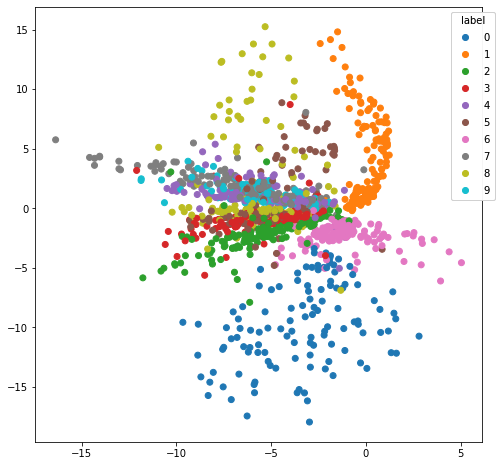


VAE:


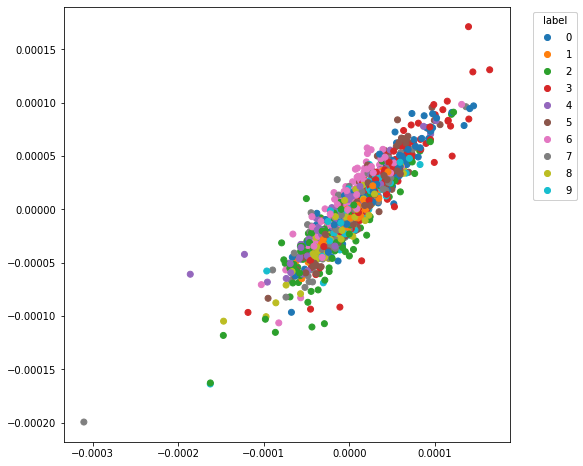

In [13]:
################ Problem 14 (2 pts) ################
# Run the current cell,
# Then answer the following cell's question in the cell itself
####################### End ########################

def visualize_2d(model, n_batch):
    assert model.z_dim == 2
    model.eval()

    n = BATCH_SIZE * n_batch
    Y, Z = torch.zeros(n, dtype=int), torch.zeros((n, model.z_dim))

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            if batch_idx >= n_batch:
                break
            current_range = range(batch_idx * BATCH_SIZE, (batch_idx+1) * BATCH_SIZE)
            Y[current_range] = y
            x = x.flatten(start_dim=1).to(device)
            _, z, _ = model(x)
            Z[current_range] = z.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='tab10')
    legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.04, 1), title="label")
    ax.add_artist(legend)
    plt.show()

print('AE:')
visualize_2d(ae_low_dim, 10)

print('\nVAE:')
visualize_2d(vae_low_dim, 10)

#### Question

<div dir="rtl"> 
دو مدل
<tt>ae_low_dim</tt> 
و 
<tt>vae_low_dim</tt> 
(که هر دوی آن‌ها فضای نهانی به بعد ۲ دارند)
را در نظر بگیرید.
وقتی داده‌ای را به هر یک از این دو مدل ورودی می‌دهیم، هر کدام از آن‌ها پس از انجام عملیات مربوط به بخش
Encoder
خود، توزیع دومتغیره‌ای از نوع گاوسی روی فضای نهان ایجاد می‌کنند. برای تعدادی داده از مجموعه‌ی داده‌های تست میانگین این توزیع‌ها را روی یک نمودار رسم کردیم
(برای هر کدام از دو مدل نامبرده به صورت جداگانه).
در واقع هر کدام از این دو نمودار، نمودار بازنمایی در فضای نهان برای تعدادی داده است. رنگ هر نقطه نیز برچسب داده‌ی مربوط به هر بازنمایی را مشخص می‌کند.

الف) 
به نظر شما کدام مدل فضای نهان بهتری را یاد گرفته‌است؟
(با ذکر دلیل)

ب)
پیشبینی می‌کنید تصاویر میانی در
interpolation
بین دو تصویر، در کدام یک از این دو مدل تصاویر معنی‌دارتری هستند؟ چرا؟
(اگر با
interpolation
آشنایی ندارید، ابتدا آخرین بخش این
notebook
را انجام دهید.)




<b>پاسخ خود را در دو قسمت زیر بنویسید:</b>

الف)
...

ب)
...
</div>

### 5.2) Reconstruction (3 pts)

Data


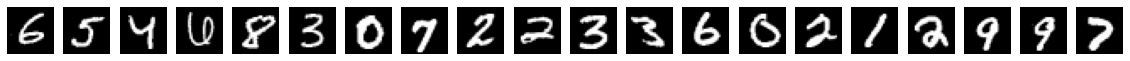

AE 2D


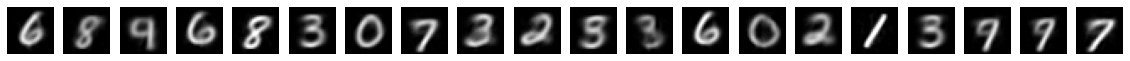

VAE 2D


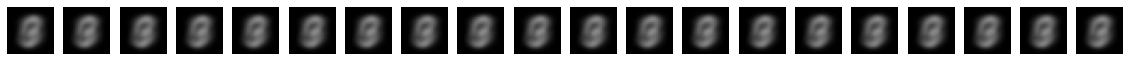

AE 32D


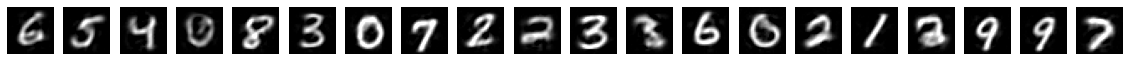

VAE 32D


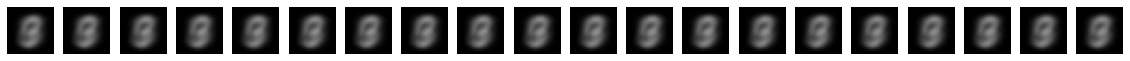

In [14]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    show(x.squeeze(1))

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu())

plot_reconstructions(models, 20)

################ Problem 15 (3 pts) ################
# Just run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################

### 5.3) Generation (3 pts)

VAE 32D


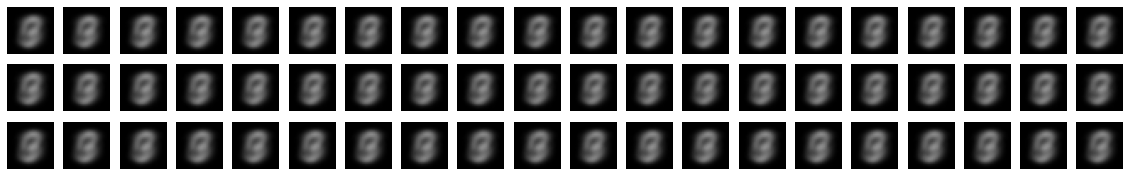

In [15]:
print('VAE %dD' % vae_high_dim.z_dim)
generated_imgs = vae_high_dim.generate(60)
show(generated_imgs.detach().cpu(), 3)

################ Problem 16 (3 pts) ################
# Just run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################

### 5.4) Interpolation (7 pts)

AE 2D


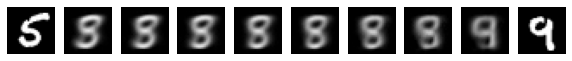

VAE 2D


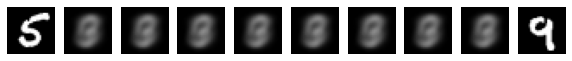

AE 32D


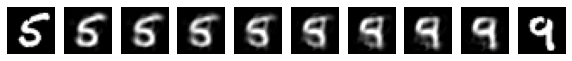

VAE 32D


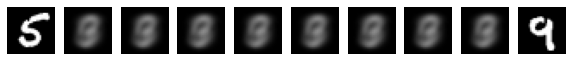

---

AE 2D


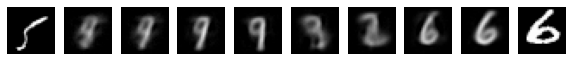

VAE 2D


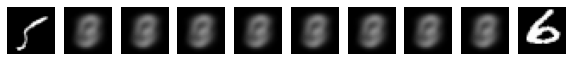

AE 32D


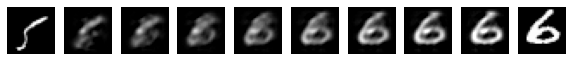

VAE 32D


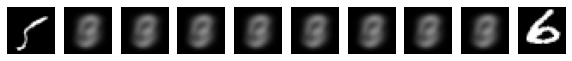

---

AE 2D


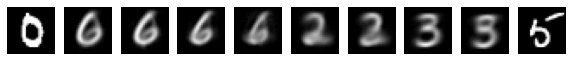

VAE 2D


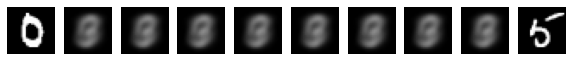

AE 32D


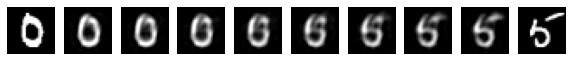

VAE 32D


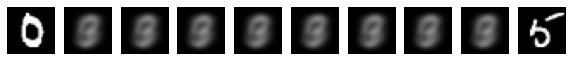

---

AE 2D


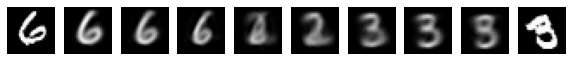

VAE 2D


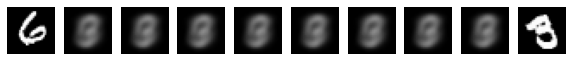

AE 32D


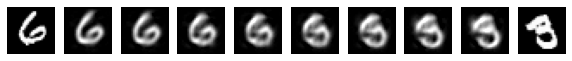

VAE 32D


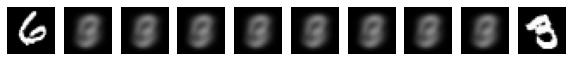

---

AE 2D


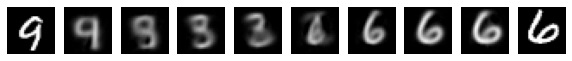

VAE 2D


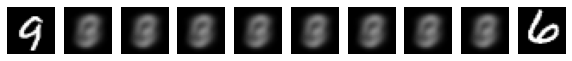

AE 32D


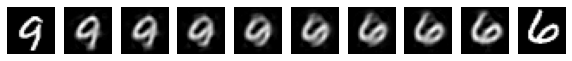

VAE 32D


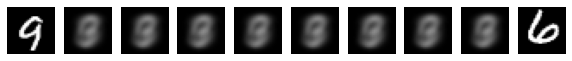

---



In [16]:
def plot_interpolations(models, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        
        for model in models:
            model.eval()
            images = None
            ################ Problem 17 (5 pts) ################
            # Find the representations of `img1, img2` in the latent space and call them `z1, z2`
            # Interpolate `n_cols` tensors (evenly spaced) between `z1` and `z2` (including both)
            # Feed these tensors to the decoder and get the resulting reconstruced images
            # Store these `n_cols` images in `images[1:-1]`
            # Set `images[0], images[-1]` to `img1, img2` respectively
            # Prepare `images` tensor to be passed into `show` function
            _, z1, _ = model(img1)
            _, z2, _ = model(img2)

            diff = (z2 - z1) / (n_cols - 1)
            z_interpolate = torch.tensor([], device=device)
            
            for j in range(1, n_cols - 1):
                z_interpolate = torch.cat((z_interpolate, z1 + j * diff))
            
            z_interpolate = z_interpolate.reshape(-1, model.z_dim)
            interpolated_images = model.decoder(z_interpolate)

            images = torch.cat((img1, *interpolated_images, img2)).reshape(-1, 784)
            images = images.detach().cpu()
            
            pass
            ####################### End ########################
            print('%s %dD' % (model.type_str, model.z_dim))
            show(images)
        print('---\n')

plot_interpolations(models, 5)

################ Problem 18 (2 pts) ################
# Run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################